# Journo-Jobs

Being an accurate representation of the analysis required for our Journo-Jobs paper at Future of Journalism 2017

In [1]:
%matplotlib inline

# import some things we need

# stdlib
import re
import os
import csv
import json
from datetime import datetime
from collections import defaultdict, Counter

#external libraries
import spacy
import textacy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# set some settings for MatPlotLib plots
# plt.style.use('seaborn-whitegrid')
mpl.rcdefaults()
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (14,10)
mpl.rcParams['axes.grid'] = True

# nlp with spacy
nlp = spacy.load('en')


In [2]:
# then we define the things we need

DATA_DIR = os.path.join(os.getcwd(), os.pardir, 'data')
print(DATA_DIR)

OUTPUT_DIR = os.path.join(os.getcwd(), os.pardir, 'output')
print(OUTPUT_DIR)

CSV_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'csv')
print(CSV_OUTPUT_DIR)

FIGURE_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'figures')
print(FIGURE_OUTPUT_DIR)

JSON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'json')
print(JSON_OUTPUT_DIR)

TXT_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'txt')
print(TXT_OUTPUT_DIR)

for directory in [OUTPUT_DIR, CSV_OUTPUT_DIR, FIGURE_OUTPUT_DIR, JSON_OUTPUT_DIR, TXT_OUTPUT_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def pprint_json(json_obj):
    print(json.dumps(json_obj, sort_keys=True, indent=4, ensure_ascii=False))  

/Users/martin/Dropbox/Coding/curop-jobs/analysis/../data
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output/csv
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output/figures
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output/json
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output/txt


## Loading the data

First we need to read the list of json files in the directory, then read the data in

In [4]:
file_names = [f for f in os.listdir(DATA_DIR) if f.endswith('.json')]
print(file_names)

['gorkana_2017-Apr-07--17-40-02.json', 'gorkana_2017-Apr-14--17-40-02.json', 'gorkana_2017-Apr-21--17-40-02.json', 'gorkana_2017-Apr-28--17-40-02.json', 'gorkana_2017-Aug-04--17-40-02.json', 'gorkana_2017-Aug-11--17-40-02.json', 'gorkana_2017-Aug-18--17-40-02.json', 'gorkana_2017-Aug-25--17-40-02.json', 'gorkana_2017-Feb-03--17-40-02.json', 'gorkana_2017-Feb-10--17-40-02.json', 'gorkana_2017-Feb-17--17-40-02.json', 'gorkana_2017-Feb-24--17-40-02.json', 'gorkana_2017-Jul-07--17-40-02.json', 'gorkana_2017-Jul-14--17-40-02.json', 'gorkana_2017-Jul-21--17-40-02.json', 'gorkana_2017-Jul-28--17-40-02.json', 'gorkana_2017-Jun-02--17-40-02.json', 'gorkana_2017-Jun-09--17-40-02.json', 'gorkana_2017-Jun-16--17-40-02.json', 'gorkana_2017-Jun-23--17-40-02.json', 'gorkana_2017-Jun-30--17-40-02.json', 'gorkana_2017-Mar-03--17-40-02.json', 'gorkana_2017-Mar-10--17-40-02.json', 'gorkana_2017-Mar-17--17-40-02.json', 'gorkana_2017-Mar-24--17-40-02.json', 'gorkana_2017-Mar-31--17-40-02.json', 'gorkana_20

Of course, we didn't use an ISO standard when we wrote the date into the filename because we're not that clever. Lets split the filename up into the source and the date, and read the files into a data structure, organised by source, then date. We'll print the count for each source and date, just for info

In [5]:
DATE_FORMAT = '%Y-%b-%d--%H-%M-%S'

source2date2jobs = defaultdict(dict)
dates = set()

for f in file_names:
    f_str = f.replace('.json', '')
    first_underscore = f_str.find('_')
    source = f_str[:first_underscore]
    print(source)
    date_string = f_str[first_underscore+1:]
    print(date_string)
    f_date = datetime.strptime(date_string, DATE_FORMAT)
    print(f_date)
    f_date_only = f_date.date()
    print(f_date_only)
    source2date2jobs[source][f_date_only] = json.load(open(os.path.join(DATA_DIR, f), 'r'))
    dates.add(f_date_only)

for source, dates in source2date2jobs.items():
    for date, jobs in source2date2jobs[source].items():
        print(source, date, len(jobs))

gorkana
2017-Apr-07--17-40-02
2017-04-07 17:40:02
2017-04-07
gorkana
2017-Apr-14--17-40-02
2017-04-14 17:40:02
2017-04-14
gorkana
2017-Apr-21--17-40-02
2017-04-21 17:40:02
2017-04-21
gorkana
2017-Apr-28--17-40-02
2017-04-28 17:40:02
2017-04-28
gorkana
2017-Aug-04--17-40-02
2017-08-04 17:40:02
2017-08-04
gorkana
2017-Aug-11--17-40-02
2017-08-11 17:40:02
2017-08-11
gorkana
2017-Aug-18--17-40-02
2017-08-18 17:40:02
2017-08-18
gorkana
2017-Aug-25--17-40-02
2017-08-25 17:40:02
2017-08-25
gorkana
2017-Feb-03--17-40-02
2017-02-03 17:40:02
2017-02-03
gorkana
2017-Feb-10--17-40-02
2017-02-10 17:40:02
2017-02-10
gorkana
2017-Feb-17--17-40-02
2017-02-17 17:40:02
2017-02-17
gorkana
2017-Feb-24--17-40-02
2017-02-24 17:40:02
2017-02-24
gorkana
2017-Jul-07--17-40-02
2017-07-07 17:40:02
2017-07-07
gorkana
2017-Jul-14--17-40-02
2017-07-14 17:40:02
2017-07-14
gorkana
2017-Jul-21--17-40-02
2017-07-21 17:40:02
2017-07-21
gorkana
2017-Jul-28--17-40-02
2017-07-28 17:40:02
2017-07-28
gorkana
2017-Jun-02--17-

In [6]:

# write out one file per source of jobs

headers = ['date', 'count']
for source, dates in source2date2jobs.items():
    
    source_data = []
    with open(os.path.join(CSV_OUTPUT_DIR, '%s.csv' % source), 'w') as output_file:
    
        writer = csv.DictWriter(output_file, headers)
        writer.writeheader()
        for date, jobs in source2date2jobs[source].items():
            source_data.append({'date': date, 'count': len(jobs)})
        writer.writerows(source_data)
        

def get_num_jobs_for_date(data, source, date):
    return len(data[source][date]) if data[source].get(date) else 0
        
        
# write a combined file
headers = ['date', 'htfp', 'gorkana', 'journalism']
rows = []
with open(os.path.join(CSV_OUTPUT_DIR, 'combined_count.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for date in dates:
        row = {
               'date': date, 
               'htfp': get_num_jobs_for_date(source2date2jobs, 'htfp', date),
               'gorkana': get_num_jobs_for_date(source2date2jobs, 'gorkana', date),
               'journalism': get_num_jobs_for_date(source2date2jobs, 'journalism', date)
              }
        rows.append(row)
    writer.writerows(rows)

    
    
        

In [7]:
# read in our combined data
combined_data = pd.read_csv(os.path.join(CSV_OUTPUT_DIR, 'combined_count.csv'), index_col=0, parse_dates=True)
combined_data = combined_data.sort_index()
print(combined_data)

            htfp  gorkana  journalism
date                                 
2017-02-02    55        0          69
2017-02-03    63      222          69
2017-02-10    71      211          73
2017-02-17    61      211          56
2017-02-24    47      193          63
2017-03-03    50      176          56
2017-03-10    48      165          61
2017-03-17    50      164          65
2017-03-24    49      161          62
2017-03-31    48      197          63
2017-04-07    48      189          70
2017-04-14     0      187          80
2017-04-21    38      187          62
2017-04-28    43      190          70
2017-05-05    37      186          55
2017-05-12    47      200          58
2017-05-19    49      212          75
2017-05-26    53      201          70
2017-06-02    47      195          73
2017-06-09    54      205          66
2017-06-16    48      204          55
2017-06-23    45      203          50
2017-06-30    40      215          45
2017-07-07    36      208          55
2017-07-14  

In [16]:
start_date = datetime.strptime('2017-02-02', '%Y-%m-%d')
end_date = datetime.strptime('2017-09-01', '%Y-%m-%d')

duration = end_date - start_date
print(duration)

211 days, 0:00:00


In [9]:
print(plt.style.available)

['seaborn-muted', 'seaborn-deep', 'bmh', 'seaborn-darkgrid', 'seaborn-talk', 'seaborn-dark', 'dark_background', 'fivethirtyeight', 'seaborn-poster', 'seaborn-ticks', 'classic', '_classic_test', 'seaborn-white', 'seaborn-dark-palette', 'grayscale', 'seaborn-bright', 'seaborn-whitegrid', 'seaborn', 'seaborn-pastel', 'ggplot', 'seaborn-notebook', 'seaborn-colorblind', 'seaborn-paper']


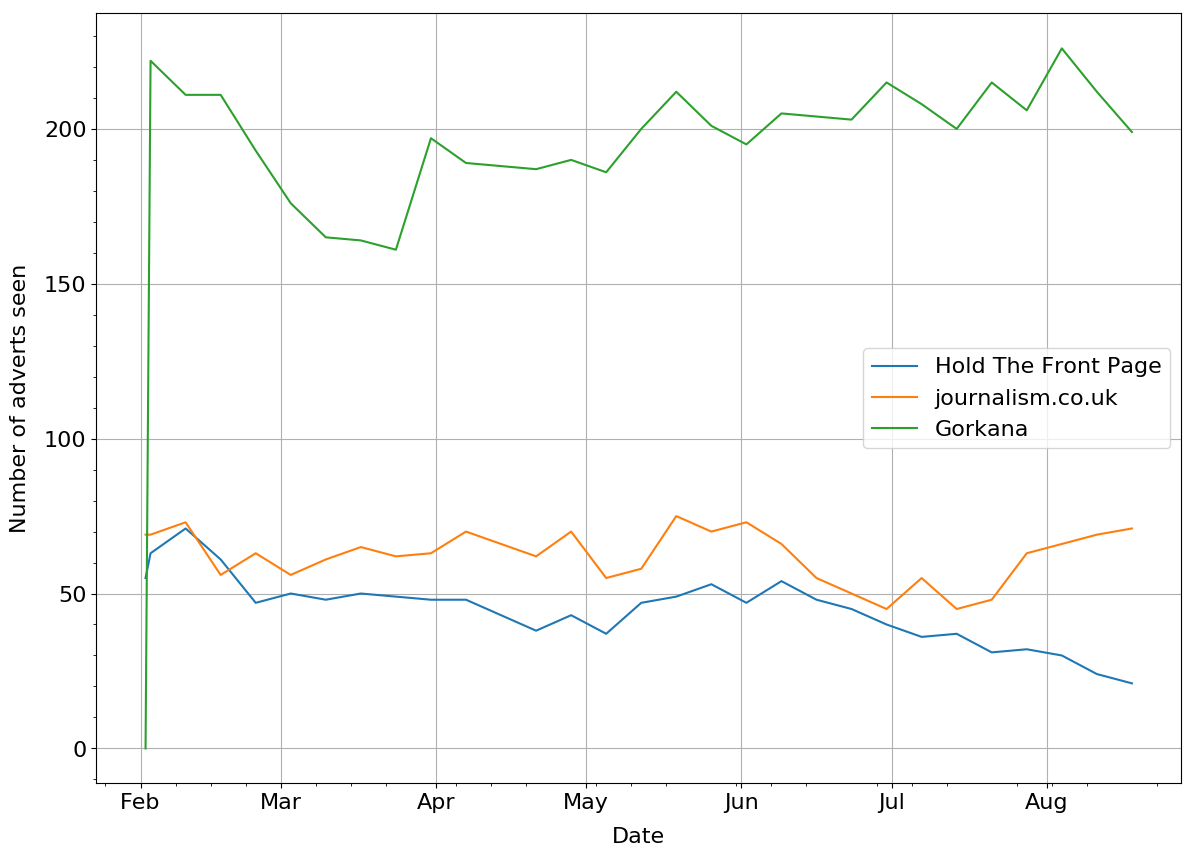

In [126]:
fig, ax = plt.subplots()

date_format = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(date_format)
ax.minorticks_on()
ax.set_ylabel('Number of adverts seen', labelpad=10)
ax.set_xlabel('Date', labelpad=10)

ax.plot(combined_data.index, combined_data['htfp'], label='Hold The Front Page')
ax.plot(combined_data.index, combined_data['journalism'], label='journalism.co.uk')
ax.plot(combined_data.index, combined_data['gorkana'], label='Gorkana')

ax.legend()
plt.show()


Of course, some of these adverts will be duplicates, and will be repeated from week to week, so we need to reduce to unique adverts only

In [136]:
# let's have a look at an advert from gorkana

a_job = source2date2jobs['gorkana'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))

{
    "Details": "\nPOLITICO is looking for experienced editors to join a dynamic group of journalists in Brussels and beyond. Ideal candidates will have sharp hands-on editing skills, a passion for digital journalism and proven leadership skills.\n\r\nThese are busy, hands-on editing jobs that will involve close coordination with teams in Brussels and across Europe to produce quality articles for a sophisticated readership on POLITICO.eu, our PRO subscription service and the weekly paper edition.\n\nQualifications\nExperienced editor or senior reporter/correspondent; knowledge of European politics and policy; strong English-language writing and editing skills; ability to work under pressure and on deadline; knowledge of other European languages is a plus.\n\nEqual Opportunity\n\nIt is POLITICO's policy to provide equal employment opportunity to all qualified individuals without regard to race, color, religion, national origin, gender, age or any other characteristic protected by local

In [132]:
# let's have a look at an advert from journalism

a_job = source2date2jobs['journalism'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))

{
    "Details": "The Sun's digital team is growing, and we want the most talented and committed digital journalists to join us.\nThe successful candidate will:\n\n\nAct as a daily go-to person for journalists and reporters seeking advice or improvements to articles\n\n\nReport each morning on the top SEO keywords driving traffic\n\n\nMake recommendations to journalists for relevant keywords and keyword combinations to target on articles\n\n\nReport each morning on top pages/articles driving SEO traffic\n\n\nPre-plan for future articles and events by building out topics and doing keyword research for upcoming exclusives or events e.g. Olympics\n\n\nMonitor trending data for newsroom suggestions and pass to editorial desks\n\n\nOptimise top pages for relevant keywords\n\n\nForward link top traffic driving pages to other more recent articles to encourage circulation\n\n\nMonitor daily output and ensure relevant cross linking in articles e.g. ensure 2 other articles links in copy, relevan

In [138]:
# let's have a look at an advert from htfp

a_job = source2date2jobs['htfp'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))

{
    "Details": "Job Description\n\nCaters News is looking for a brilliant reporter to join the team at our global headquarters in Birmingham, UK.\nOur journalists fill the pages of national newspapers with top-quality stories every day, and we’re on the hunt for a reporter who can hit the ground running.\nWe’re looking for a real ‘people-person’ who can start up a conversation with anyone, and get even the most reluctant interviewee to open up.\nIf you’re a switched-on, creative, and ambitious journalist who wants to see your stories published in media outlets across the globe, then it’s the ideal opportunity.\nAs with all the best jobs in journalism, having a thick skin and a sense of humour is also helpful.\nSuccessful candidates will be joining a fun, creative team with a real buzz – and an opportunity to really make a name for yourself.\nYou’ll need to have an NCTJ qualification, as well as your own transport and a driving licence.\nThe ideal candidate will have experience at an 

In [10]:
# let's enrich the jobs by adding their source and the date they were seen, and replace the newline characters with whitespace

for source, dates in source2date2jobs.items():
    for date, jobs in source2date2jobs[source].items():
        for job in jobs:
            job['DateSeen'] = date.strftime('%Y-%m-%d')
            job['Source'] = source
            job['Details'] = job['Details'].replace('\n', ' ')
            job['link'] = job['link'].split('?')[0]
            
a_job = source2date2jobs['htfp'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))            

{
    "DateSeen": "2017-04-28",
    "Details": "Job Description  Newsquest Somerset is looking for a trainee reporters working across a series of weekly titles in the South West. The four-title series – including the County Gazette – covers a patch in Somerset stretching from the stunning coastline at Minehead and Exmoor to the county town of Taunton, to Chard, Bridgwater and Burnham-on-Sea, with the likes of the Glastonbury Festival and the new Hinkley Point C nuclear power station development on the doorstep, so we are keen to hear from a reporter keen to get to the heart of the community and cover the stories that matter. You will be happy writing about anything and everything and brimming with ideas of how we can best offer our content to readers both in print and in the world of multimedia, as well as finding exceptional off-diary exclusives. Applicants will ideally be NCTJ qualified, including 100 wpm shorthand, with the desire to make their mark at an exciting time for the regio

In [13]:
count = defaultdict(int)

for source, dates in source2date2jobs.items():
    for date, jobs in source2date2jobs[source].items():
        count[source] += len(jobs)
print(count)
        

defaultdict(<class 'int'>, {'gorkana': 6149, 'htfp': 1330, 'journalism': 2031})


In [14]:
duplicate_jobs_removed_by_url = {}

for source, dates in source2date2jobs.items():
    duplicate_jobs_removed_by_url[source] = []
    for date, jobs in source2date2jobs[source].items():
        for job in jobs:
            existing_links = [j['link'] for j in duplicate_jobs_removed_by_url[source]]
            if not job['link'] in existing_links:
                duplicate_jobs_removed_by_url[source].append(job)
    print(source, len(duplicate_jobs_removed_by_url[source]))
    
for source, jobs in duplicate_jobs_removed_by_url.items():
    with open(os.path.join(JSON_OUTPUT_DIR, '%s.json' % source), 'w') as output_file:
        json.dump(jobs, output_file, ensure_ascii=False, indent=4, sort_keys=True)
    
            

gorkana 1768
htfp 442
journalism 565


In [15]:
%%time

def find_matches(combined_jobs, duplicates, jobs_to_check):
    
    for this_job in jobs_to_check:
        match = False
        for that_job in combined_jobs:
            # check the similarity between the role title as a whole item
            role_ratio = fuzz.ratio(this_job['Role'], that_job['Role'])
            
            # only do further processing if the role is the same
            if role_ratio > 97:
                
                # check the similarity between the job details - can tokenize this and treat it as a bag of words
                details_ratio = fuzz.token_set_ratio(this_job['Details'], that_job['Details'])

                # if the similarities are high, we may have a match
                if details_ratio > 90:

                    # lets check the date - if they're seen more than a month after one another it
                    # may be a re-posting of the same job (or job description) so we need to count it
                    this_job_date = datetime.strptime(this_job['DateSeen'], '%Y-%m-%d')
                    that_job_date = datetime.strptime(that_job['DateSeen'], '%Y-%m-%d')

                    if this_job_date < that_job_date:
                        difference = that_job_date - this_job_date
                    else:
                        difference = this_job_date - that_job_date

                    if difference.days < 31:
                        duplicates.append((this_job, that_job))
                        match = True

                        print('\nMATCH!*********************')
                        print(difference)
                        print(this_job['Role'], this_job['link'])
                        print(that_job['Role'], that_job['link'])
                        break

        if not match:
            combined_jobs.append(this_job)
    
    return combined_jobs, duplicates

            

combined_jobs, duplicates = find_matches([], [], duplicate_jobs_removed_by_url['gorkana'])
print(len(combined_jobs), len(duplicates))
combined_jobs, duplicates = find_matches(combined_jobs, duplicates, duplicate_jobs_removed_by_url['htfp'])
print(len(combined_jobs), len(duplicates))
combined_jobs, duplicates = find_matches(combined_jobs, duplicates, duplicate_jobs_removed_by_url['journalism'])
print(len(combined_jobs), len(duplicates))




MATCH!*********************
21 days, 0:00:00
Meetings & Incentive Travel Magazine & www.meetpie.com, Reporter http://www.gorkanajobs.co.uk/job/71354/meetings-and-incentive-travel-magazine-and-www-meetpie-com-reporter/
Meetings & Incentive Travel Magazine & www.meetpie.com, Reporter http://www.gorkanajobs.co.uk/job/70411/meetings-and-incentive-travel-magazine-and-www-meetpie-com-reporter/

MATCH!*********************
21 days, 0:00:00
The Sunday Times, Digital Content Editor - Style http://www.gorkanajobs.co.uk/job/71240/the-sunday-times-digital-content-editor-style/
The Sunday Times, Digital Content Editor - Style http://www.gorkanajobs.co.uk/job/69329/the-sunday-times-digital-content-editor-style/

MATCH!*********************
21 days, 0:00:00
Your Fitness Magazine, Editorial Assistant http://www.gorkanajobs.co.uk/job/71212/your-fitness-magazine-editorial-assistant/
Your Fitness Magazine, Editorial Assistant http://www.gorkanajobs.co.uk/job/70471/your-fitness-magazine-editorial-assista

Multimedia Journalist (Trainee) http://www.holdthefrontpage.co.uk/jobsboard/view/multimedia-journalist-trainee-sale/

MATCH!*********************
21 days, 0:00:00
Trainee Reporter http://www.holdthefrontpage.co.uk/jobsboard/view/trainee-reporter-guildford-7/
Trainee Reporter http://www.holdthefrontpage.co.uk/jobsboard/view/trainee-reporter-guildford-6/

MATCH!*********************
0:00:00
Video Reporter http://www.holdthefrontpage.co.uk/jobsboard/view/video-reporter-cardiff/
Video Reporter http://www.holdthefrontpage.co.uk/jobsboard/view/video-reporter-swansea/

MATCH!*********************
0:00:00
Video Producer http://www.holdthefrontpage.co.uk/jobsboard/view/video-producer-swansea/
Video Producer http://www.holdthefrontpage.co.uk/jobsboard/view/video-producer-cardiff/

MATCH!*********************
0:00:00
Video Reporter (News) http://www.holdthefrontpage.co.uk/jobsboard/view/video-reporter-news-birmingham/
Video Reporter (News) http://www.holdthefrontpage.co.uk/jobsboard/view/video-re


MATCH!*********************
21 days, 0:00:00
Reporter https://www.journalism.co.uk/media-jobs/reporter/s75/a705604/
Reporter http://www.holdthefrontpage.co.uk/jobsboard/view/reporter-the-morning-advertiser-crawley/

MATCH!*********************
0:00:00
G10 Foreign exchange and economics reporter https://www.journalism.co.uk/media-jobs/g10-foreign-exchange-and-economics-reporter/s75/a704303/
G10 Foreign exchange and economics reporter https://www.journalism.co.uk/media-jobs/g10-foreign-exchange-and-economics-reporter-home-based/s75/a704267/

MATCH!*********************
21 days, 0:00:00
Senior reporter/chief reporter - Property Week https://www.journalism.co.uk/media-jobs/senior-reporter-chief-reporter-property-week/s75/a703954/
Senior reporter/chief reporter - Property Week https://www.journalism.co.uk/media-jobs/senior-reporter-chief-reporter-property-week/s75/a702618/

MATCH!*********************
21 days, 0:00:00
Researcher/writer https://www.journalism.co.uk/media-jobs/researcher-wri

In [17]:
with open(os.path.join(JSON_OUTPUT_DIR, 'duplicates.json'), 'w') as output_file:
    json.dump(duplicates, output_file, ensure_ascii=False, indent=4, sort_keys=True)
    
with open(os.path.join(JSON_OUTPUT_DIR, 'combined_jobs.json'), 'w') as output_file:
    json.dump(combined_jobs, output_file, ensure_ascii=False, indent=4, sort_keys=True)
    


In [18]:
combined_jobs = json.load(open(os.path.join(JSON_OUTPUT_DIR, 'combined_jobs.json'), 'r'))
print(len(combined_jobs))

for i, job in enumerate(combined_jobs):
    with open(os.path.join(TXT_OUTPUT_DIR, '%s_%d.txt' % (job['Source'], i % 50)), 'a') as output_file:
        output_file.write(job['Details'])

2693


# End of filtering?

So now we've filtered the data down and extracted all the duplicates, let's check the totals again:

In [19]:
job_count = Counter()
date_count = Counter()
source2datecount = defaultdict(Counter)

for job in combined_jobs:
    
    job_count[job['Source']] += 1
    source2datecount[job['Source']][job['DateSeen']] += 1
    date_count[job['DateSeen']] += 1
    
print(job_count)
print(date_count)

Counter({'gorkana': 1740, 'journalism': 547, 'htfp': 406})
Counter({'2017-02-10': 347, '2017-04-28': 301, '2017-08-25': 284, '2017-06-23': 268, '2017-03-24': 261, '2017-05-19': 241, '2017-07-14': 139, '2017-03-03': 118, '2017-07-21': 97, '2017-06-30': 87, '2017-02-03': 85, '2017-04-14': 67, '2017-09-01': 64, '2017-06-02': 62, '2017-03-17': 42, '2017-08-18': 36, '2017-07-28': 30, '2017-04-07': 26, '2017-08-11': 23, '2017-02-24': 18, '2017-06-16': 15, '2017-05-05': 12, '2017-05-12': 11, '2017-03-10': 10, '2017-03-31': 9, '2017-06-09': 9, '2017-08-04': 8, '2017-04-21': 7, '2017-07-07': 7, '2017-05-26': 4, '2017-02-17': 4, '2017-02-02': 1})


In [20]:
# write a combined file
headers = ['date', 'count']
rows = []
with open(os.path.join(CSV_OUTPUT_DIR, 'combined_date_count.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for date, count in date_count.items():
        row = {
               'date': date, 
               'count': count
              }
        rows.append(row)
    writer.writerows(rows)

headers = ['date', 'total', 'gorkana', 'htfp', 'journalism']
rows = []
    
with open(os.path.join(CSV_OUTPUT_DIR, 'combined_date_count_by_source.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for date, count in date_count.items():
        row = {
                'date': date, 
                'total': count,
                'gorkana': source2datecount['gorkana'][date],
                'htfp': source2datecount['htfp'][date],
                'journalism': source2datecount['journalism'][date],
              }
        rows.append(row)
    writer.writerows(rows)

In [21]:
# read in our combined data
deduped_data = pd.read_csv(os.path.join(CSV_OUTPUT_DIR, 'combined_date_count_by_source.csv'), index_col=0, parse_dates=True)
deduped_data = deduped_data.sort_index()
print(deduped_data)

            total  gorkana  htfp  journalism
date                                        
2017-02-02      1        0     0           1
2017-02-03     85       57    14          14
2017-02-10    347      211    66          70
2017-02-17      4        2     1           1
2017-02-24     18       12     3           3
2017-03-03    118       88    20          10
2017-03-10     10        2     1           7
2017-03-17     42       11    13          18
2017-03-24    261      161    42          58
2017-03-31      9        7     1           1
2017-04-07     26       13    13           0
2017-04-14     67       50     0          17
2017-04-21      7        1     6           0
2017-04-28    301      190    42          69
2017-05-05     12       11     1           0
2017-05-12     11       10     0           1
2017-05-19    241      155    34          52
2017-05-26      4        2     1           1
2017-06-02     62       23    20          19
2017-06-09      9        4     2           3
2017-06-16

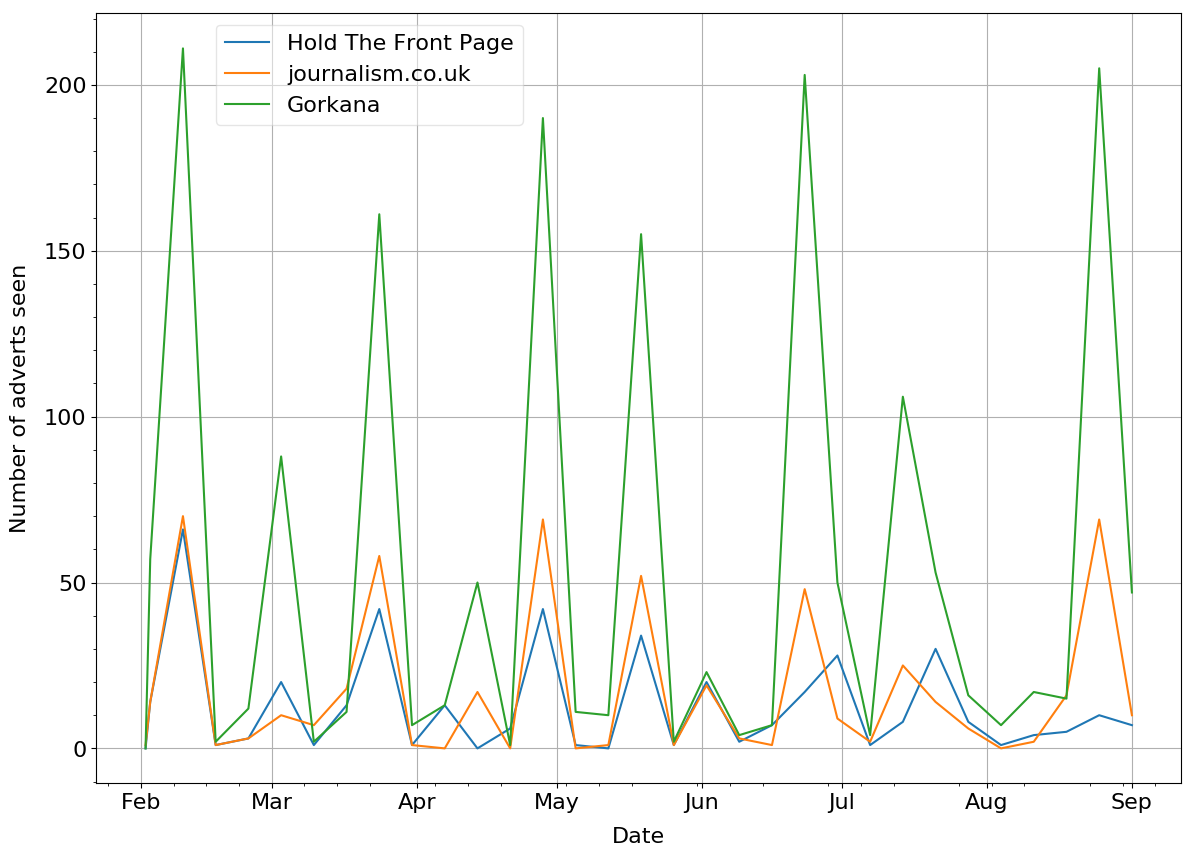

In [22]:
fig, ax = plt.subplots()

date_format = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(date_format)
ax.minorticks_on()
ax.set_ylabel('Number of adverts seen', labelpad=10)
ax.set_xlabel('Date', labelpad=10)

ax.plot(deduped_data.index, deduped_data['htfp'], label='Hold The Front Page')
ax.plot(deduped_data.index, deduped_data['journalism'], label='journalism.co.uk')
ax.plot(deduped_data.index, deduped_data['gorkana'], label='Gorkana')

ax.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0), framealpha=0.5)
plt.show()

In [23]:
role_count = Counter()

for job in combined_jobs:
    role_count[job['Role']] += 1
    
print(role_count.most_common(100))

[('Reporter', 67), ('Trainee Reporter', 39), ('Senior Reporter', 28), ('Editor', 25), ('Journalist', 20), ('Editorial assistant', 11), ('Deputy editor', 10), ('Chief Reporter', 9), ('News Editor', 8), ('Content Editor', 8), ('Staff writer', 7), ('Deputy Editor', 7), ('News editor', 7), ('Reporters', 7), ('Senior reporter', 6), ('Assistant editor', 6), ('Multimedia Journalist', 6), ('Multimedia Journalist (Trainee)', 5), ('Broadcast journalist', 5), ('News reporter', 5), ('Photographer', 5), ('Multimedia Reporter', 5), ('Deputy News Editor', 5), ('Sub-editor', 4), ('Which?, (Senior) Researcher / Writer', 4), ('Assistant Editor', 4), ('Production editor', 4), ('News Reporter', 4), ('Trainee Reporters', 4), ("What's On Writer", 4), ('The Sun, SEO Editor', 3), ('S&P Global Market Intelligence, Reporter - Consumer News', 3), ('Feature Writer', 3), ('MailOnline, Community Moderator', 3), ('Video Producer', 3), ('Sub-Editor', 3), ('Trainee Multimedia Reporter', 3), ('Money Observer, Web Conte

In [24]:
# Role is usually full of other information, so if we can, let's remove it

role_count = Counter()

rows = []

headers = ['source', 'original', 'corrected']
    
with open(os.path.join(CSV_OUTPUT_DIR, 'roles.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()

    for job in combined_jobs:

        role = job['Role']

        # some gorkana jobs are "role, organisation - state" so remove these first if present
        if job['Source'] == 'gorkana':
            role = re.sub(', [\w\s]+ - ([A-Z]{2})', '', role)
            # or in one case
            role = re.sub(', [\w\s]+ - [Hong Kong]+', '', role)
        
        # other jobs (including other gorkana) are "organisation, role", 
        # so remove the employer/organisation if it's there
        splits = role.split(',')
        if len(splits) > 1:
            # journalism.co.uk is "role, organisation"
            if job['Source'] == 'journalism':
                role = splits[0]
            # everything else is "organisation, role"
            else:
                role = splits[1]
        else:
            role = splits[0]

        if role.find('('):
            role = role.split('(')[0]
            
        if role.find(' - '):
            role = role.split(' - ')[0]      

        role_count[role.strip().rstrip('s').lower()] += 1

        rows.append({
            'source': job['Source'],
            'original': job['Role'],
            'corrected': role
        })
    
    writer.writerows(rows)
    
print(role_count.most_common(50))

rows = []

headers = ['role', 'count']
    
with open(os.path.join(CSV_OUTPUT_DIR, 'roles_count.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for role, count in role_count.items():
        rows.append({
            'role': role,
            'count': count
        })
    writer.writerows(rows)

[('reporter', 176), ('editor', 118), ('senior reporter', 59), ('deputy editor', 58), ('editorial assistant', 54), ('trainee reporter', 46), ('news editor', 44), ('news reporter', 35), ('sub-editor', 35), ('journalist', 35), ('staff writer', 31), ('assistant editor', 29), ('production editor', 26), ('features writer', 21), ('content editor', 19), ('digital editor', 18), ('editor-in-chief', 17), ('features editor', 16), ('associate editor', 14), ('managing editor', 14), ('multimedia journalist', 13), ('copy editor', 12), ('art editor', 12), ('designer', 12), ('chief reporter', 12), ('art director', 11), ('junior designer', 11), ('head of content', 9), ('financial journalist', 9), ('junior reporter', 9), ('picture editor', 8), ('data journalist', 8), ('deputy news editor', 8), ('assistant news editor', 8), ('sub editor', 8), ('business editor', 8), ('copywriter', 8), ('digital producer', 8), ('digital journalist', 7), ('senior editor', 7), ('writer', 7), ('trainee news reporter', 7), ('br

In [25]:
role_data = pd.read_csv(os.path.join(CSV_OUTPUT_DIR, 'roles_count.csv'), index_col=0)
role_data.sort_values(by='count', inplace=True, ascending=False)
print(role_data)

                                                   count
role                                                    
reporter                                             176
editor                                               118
senior reporter                                       59
deputy editor                                         58
editorial assistant                                   54
trainee reporter                                      46
news editor                                           44
journalist                                            35
news reporter                                         35
sub-editor                                            35
staff writer                                          31
assistant editor                                      29
production editor                                     26
features writer                                       21
content editor                                        19
digital editor                 

In [26]:
single_adverts = role_data.loc[role_data['count'] == 1]
print(single_adverts.size)

812


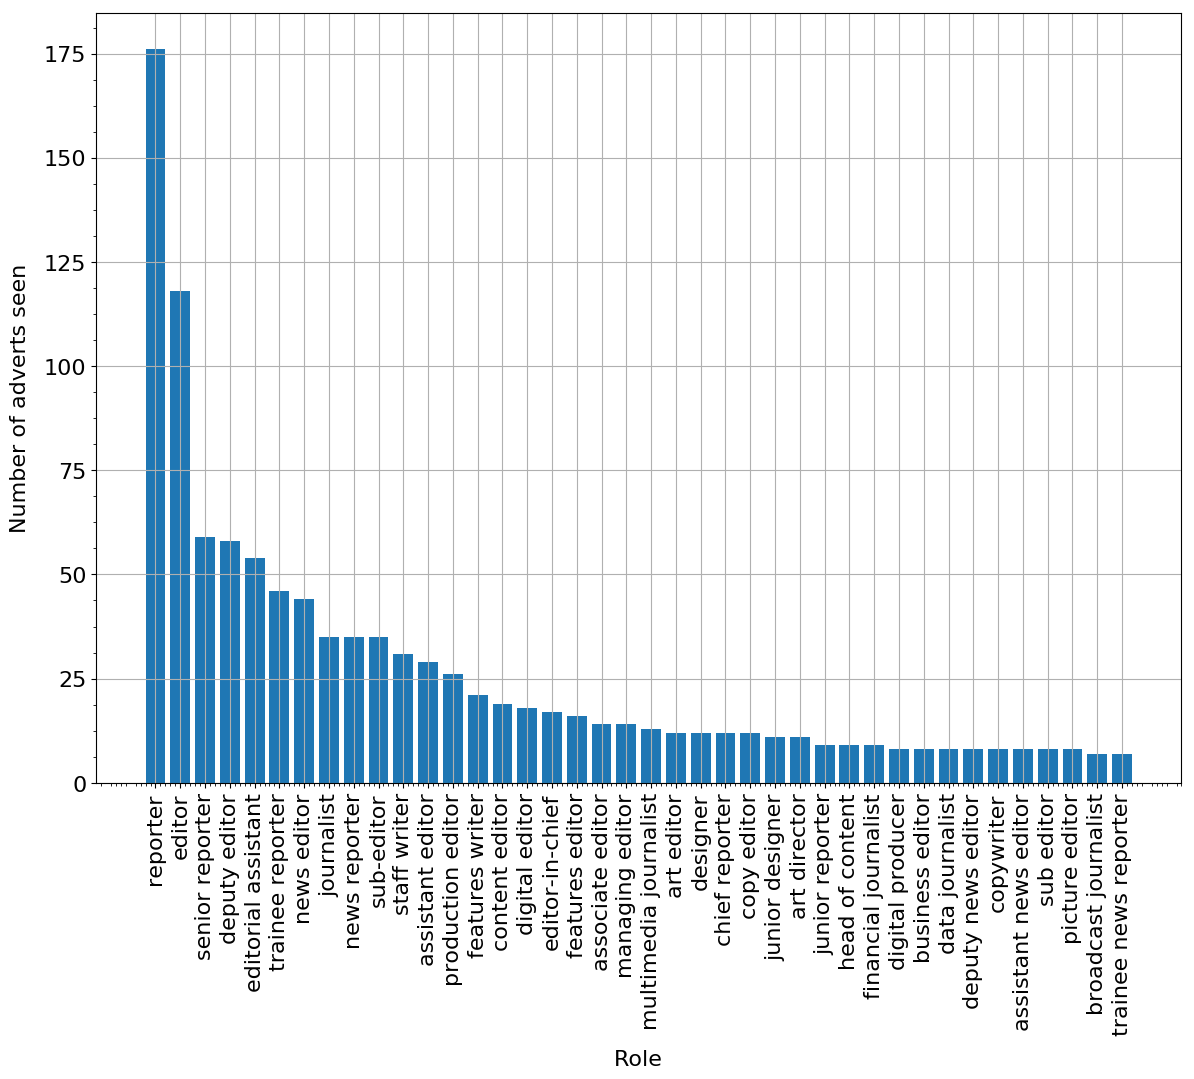

In [27]:
num_bars = 40

fig, ax = plt.subplots()

ax.minorticks_on()
ax.set_ylabel('Number of adverts seen', labelpad=10)
ax.set_xlabel('Role', labelpad=10)

ax.bar(np.arange(num_bars), role_data['count'][:num_bars])
ax.set_xticks(np.arange(num_bars))
ax.set_xticklabels(role_data.index[:num_bars], rotation=90)

#ax.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0), framealpha=0.5)
plt.show()

In [269]:
job = combined_jobs[0]
pprint_json(job)

{
    "DateSeen": "2017-03-10",
    "Details": " POLITICO is looking for experienced editors to join a dynamic group of journalists in Brussels and beyond. Ideal candidates will have sharp hands-on editing skills, a passion for digital journalism and proven leadership skills. \r These are busy, hands-on editing jobs that will involve close coordination with teams in Brussels and across Europe to produce quality articles for a sophisticated readership on POLITICO.eu, our PRO subscription service and the weekly paper edition.  Qualifications Experienced editor or senior reporter/correspondent; knowledge of European politics and policy; strong English-language writing and editing skills; ability to work under pressure and on deadline; knowledge of other European languages is a plus.  Equal Opportunity  It is POLITICO's policy to provide equal employment opportunity to all qualified individuals without regard to race, color, religion, national origin, gender, age or any other characteristi

In [28]:
doc = nlp(job['Details'])
doc = textacy.Doc(doc, lang='en')
print(doc)
# for ent in doc.ents:
#     print(ent.label_, ent.text)

Doc(522 tokens; "This role sits within a team of data specialist...")


In [29]:
ad = textacy.extract.acronyms_and_definitions(doc)
print(ad)

{'BBC': '', 'M&A': ''}


In [320]:
bot = doc.to_bag_of_terms(as_strings=True)
print(bot)

{'experienced editor': 2, 'consider': 1, 'produce quality article': 1, 'paper': 1, 'service': 1, 'quality': 1, 'subscription service': 1, 'european politic': 1, 'form': 1, 'ability': 1, 'gender': 1, 'ideal candidate': 1, 'writing and editing': 1, 'journalist in brussels': 1, 'application': 3, 'paper edition': 1, "'s": 1, 'journalism and prove': 1, 'consider complete application': 1, 'produce quality': 1, 'editor': 2, 'pressure': 1, 'politic and policy': 1, 'editing': 3, 'reporter': 1, 'characteristic protect': 1, 'sample in english': 1, 'language': 2, 'join': 1, 'regard': 1, 'religion': 1, 'qualifications experienced editor': 1, 'policy': 2, 'national origin': 1, 'regard to race': 1, 'qualifications experienced': 1, 'journalism': 1, 'additional': 1, 'law and regulation': 1, 'language writing': 1, 'write': 2, 'consider complete': 1, 'senior reporter': 1, 'europe': 1, 'journalist': 1, 'application instruction': 1, 'sharp hand': 1, "politico 's policy": 1, 'politic': 1, 'cv': 2, 'leadersh

In [281]:
ents = textacy.extract.named_entities(doc)
for ent in ents:
    print(ent)

POLITICO
Brussels
Ideal
Brussels
Europe
POLITICO.eu
PRO
weekly
Qualifications Experienced
European
English
European
POLITICO
CV
English
CV
English


In [299]:
bigrams = textacy.extract.ngrams(doc, 3)
for bigram in bigrams:
    print(bigram)

POLITICO is looking
looking for experienced
editors to join
join a dynamic
group of journalists
journalists in Brussels
passion for digital
journalism and proven
proven leadership skills
involve close coordination
coordination with teams
teams in Brussels
Europe to produce
produce quality articles
readership on POLITICO.eu
PRO subscription service
weekly paper edition
Qualifications Experienced editor
editor or senior
knowledge of European
politics and policy
writing and editing
ability to work
work under pressure
POLITICO's policy
policy to provide
provide equal employment
equal employment opportunity
individuals without regard
regard to race
protected by local
laws and regulations
Additional Application Instructions
send a cover
CV and writing
English by completing
completing the application
consider complete applications
CV and writing
samples in English


In [284]:
noun_chunks = textacy.extract.noun_chunks(doc)
for noun_chunk in noun_chunks:
    print(noun_chunk)

 POLITICO
experienced editors
dynamic group
journalists
Brussels
Ideal candidates
sharp hands
editing skills
digital journalism
proven leadership skills
busy, hands
editing jobs
close coordination
teams
Brussels
Europe
quality articles
sophisticated readership
POLITICO.eu
Qualifications Experienced editor
senior reporter/correspondent
knowledge
European politics
policy
strong English-language writing and editing skills
ability
pressure
deadline
knowledge
other European languages
plus
Equal Opportunity
It
POLITICO's policy
equal employment opportunity
qualified individuals
regard
race
color
religion
national origin
local laws
regulations
you
opportunity
cover letter
samples
English
application form
we
complete applications
letter
samples
English


In [293]:
noun_chunks = textacy.extract.noun_chunks(doc)
sss = textacy.extract.semistructured_statements(doc, 'knowledge')
for ss in sss:
    print(ss)

In [294]:
svos = textacy.extract.subject_verb_object_triples(doc)
for svo in svos:
    print(svo)

(editors, to join, group)
(Ideal candidates, will have, hands)
(These, are, hands)
(that, will involve, close coordination)
(that, will involve, to produce)
(Qualifications Experienced editor, is, plus)
(correspondent, is, plus)
(knowledge, is, plus)
(skills, is, plus)
(ability, is, plus)
(knowledge, is, plus)
(Opportunity, is, policy)
(Opportunity, is, to provide)
(It, is, policy)
(It, is, to provide)
(we, consider, applications)


In [298]:
keyterms = textacy.keyterms.key_terms_from_semantic_network(doc, normalize='lower', ranking_algo='divrank')
for keyterm in keyterms:
    print(keyterm)

('opportunity', 0.02897995252590078)
('skills', 0.025805904904237807)
('brussels', 0.022080481795002868)
('application', 0.01960076718918476)
('experienced', 0.019475076500719057)
('english', 0.018985687893785772)
('editing', 0.01627384090199109)
('letter', 0.015622332372854314)
('knowledge', 0.015360236834446043)
('policy', 0.015352645015616723)


In [300]:
sgranks = textacy.keyterms.sgrank(doc)
for sgrank in sgranks:
    print(sgrank)

('additional application instruction', 0.11444481114056766)
('qualifications experienced editor', 0.08907098661120615)
('equal employment opportunity', 0.08688435053307518)
('editing skill', 0.07606360227374814)
('weekly paper edition', 0.056495477893413124)
('experienced editor', 0.051000213449534926)
('pro subscription service', 0.04128399188093457)
('leadership skill', 0.028396591960748112)
('digital journalism', 0.027384795026647583)
('editing job', 0.025310845116756887)


In [366]:
# lets do some pre-processing of the text
jd = combined_jobs[2]['Details']
print(jd)
print('*******\n')
jd_processed = textacy.preprocess.preprocess_text(jd, fix_unicode=True, no_urls=True, no_emails=True, no_contractions=True)
print(jd_processed)

 Developing good industry and PR contacts is an important part of your role, and you will be expected to represent the brands on press trips and at product launches in the UK and around the world.  KEY SKILLS  Recognised journalism qualification Writing experience online or in print Good knowledge of consumer technology  Excellent verbal and written communication skills  The ability to work under pressure and as part of a team Social media and video skills An understanding of SEO and web analytics   Apply by completing the application form below. 
*******

Haymarket Media Group, one of the world's leading specialist media companies, is looking for talented new journalism graduates to join its market-leading consumer technology division. Print and online writing experience is a bonus, while an enthusiasm for all things tech is essential. The publisher of Stuff and What Hi-Fi? leads the way when it comes to offering news, reviews and features on the latest gadgets, from TVs to tablets, s

In [31]:
for job in combined_jobs:
    job['processed_details'] = textacy.preprocess.preprocess_text(job['Details'], fix_unicode=True, no_urls=True, no_emails=True, no_contractions=True)

In [32]:
for job in combined_jobs:
    job['processed_details'] = job['processed_details'].split('Equal Opportunity')[0]   
    job['processed_details'] = job['processed_details'].split('About Us')[0]   
    job['processed_details'] = job['processed_details'].split('Additional Application Instructions')[0]
    # remove journalism.co.uk stuff when processing
    job['processed_details'] = job['processed_details'].split('Apply Online Save for later')[0]
    # remove htfp stuff when processing
    job['processed_details'] = job['processed_details'].split('Please mention HoldtheFrontPage')[0]
    # also 'How to Apply
    job['processed_details'] = job['processed_details'].split('How to apply')[0]
    
    # split on '.'
    sentences = job['processed_details'].split('.')
    job['processed_details'] = ''
    for sent in sentences:
        if not 'completing the application' in sent:
            job['processed_details'] += sent

In [485]:
pprint_json(combined_jobs[2200])

{
    "DateSeen": "2017-02-10",
    "Details": "The Grocer is looking for a multi-media business journalist to lead our coverage of the alcoholic drinks industry in all its intoxicating, colourful and controversial glory. You’ll be covering sales performance, consumer trends, innovation, ranging & merchandising, branding, pricing etc. across the leading suppliers and retailers. Your brief is to break important stories, with a licence to write (and record and collate) intelligent and thought-provoking blogs, analysis pieces, features and profiles. You will also be responsible for developing The Grocer’s Drink Awards. Ideally you’ll have previous knowledge of the drinks business, though this is not essential. The qualities that are non-negotiable are:  The personality, curiosity and intelligence to develop and work senior-level contacts.    A strong interest in the topic, and experience of business or consumer affairs news.   Multi-media skills, including an understanding of new media, s

In [33]:
corpus = textacy.Corpus('en', texts=[job['processed_details'] for job in combined_jobs])

In [34]:
corpus.save(os.getcwd(), name='journo-jobs', compression='gzip')

In [488]:
print(corpus)
for doc in corpus:
    print(doc)

Corpus(2548 docs; 889187 tokens)
Doc(120 tokens; "POLITICO is looking for experienced editors to ...")
Doc(496 tokens; "Company Description: Incisive Media is an AOP '...")
Doc(276 tokens; "Haymarket Media Group, one of the world's leadi...")
Doc(271 tokens; "A prestigious academic publisher in central Lon...")
Doc(656 tokens; "Are you passionate about acoustic guitars, thei...")
Doc(235 tokens; "MarketWatch seeks a reporter to help cover the ...")
Doc(123 tokens; "Broadcast is looking for an editor to lead its ...")
Doc(830 tokens; "The Economist Group is the leading source of an...")
Doc(631 tokens; "GRADUATE JOURNALISM / EDITORIAL OPPORTUNITY at ...")
Doc(126 tokens; "The Family – the content creation agency at Sho...")
Doc(136 tokens; "Working closely with the Community Coordinator,...")
Doc(107 tokens; "Role objectives: The Style Picture Editor is re...")
Doc(457 tokens; "The role is within the Communications Dept, rep...")
Doc(160 tokens; "William Reed is launching a new service 

Doc(470 tokens; "The energy of a newsroom The pace of a trading ...")
Doc(326 tokens; "The Open Society Programme on Independent Journ...")
Doc(480 tokens; "There has never been a better time to join Gork...")
Doc(563 tokens; "PageTiger is seeking an Editorial Assistant to ...")
Doc(322 tokens; "KICCA Media is a fast growing UK content busine...")
Doc(103 tokens; "The Sun is looking for a Deputy Night Picture E...")
Doc(719 tokens; "Company Description: Incisive Media is an AOP '...")
Doc(506 tokens; "Cision is a leading media communication technol...")
Doc(341 tokens; "JOURNAL INTERNATIONAL EXPERIENCE is one of Euro...")
Doc(223 tokens; "JOB PURPOSE: To edit the copy to a high standar...")
Doc(545 tokens; "PinkNews is the world's largest LGBT+ news publ...")
Doc(457 tokens; "Last Word is seeking a Digital Designer to join...")
Doc(157 tokens; "Leading hedge fund media brand HFM Global is lo...")
Doc(317 tokens; "A leading independent media company has a great...")
Doc(86 tokens; "We a

Doc(229 tokens; "Job Description Department: News Editorial – Ci...")
Doc(116 tokens; "Job Description The Evening Express is looking ...")
Doc(157 tokens; "Job Description THE Dorset Echo has a vacancy f...")
Doc(441 tokens; "Job Description Video-led football reporter – B...")
Doc(702 tokens; "Job Description What's On Writer Cambridge £Com...")
Doc(581 tokens; "Job Description Job Introduction Trending video...")
Doc(540 tokens; "Job Description JOB TITLE: REPORTER RESPONSIBLE...")
Doc(833 tokens; "Job Description Vacancies - CTR Travel Writers/...")
Doc(498 tokens; "Job Description Job Description Insider is one ...")
Doc(462 tokens; "Job Description Trainee Digital Journalist – Gl...")
Doc(610 tokens; "Job Description Trinity Mirror Solutions is loo...")
Doc(161 tokens; "Job Description The Bolton News/Bury Times is l...")
Doc(285 tokens; "Job Description MINISTRY OF JUSTICE PRESS OFFIC...")
Doc(256 tokens; "Job Description Are you a first class journalis...")
Doc(563 tokens; "Job

In [35]:
counts = corpus.word_freqs(as_strings=True, normalize='lemma', weighting='idf')
counts_ranking = Counter(counts)
print(counts_ranking.most_common(40))

[('-PRON-', 29640), ('work', 6469), ('news', 5955), ('content', 5588), ('team', 4717), ('experience', 4712), ("'s", 3513), ('skill', 3443), ('editor', 3423), ('digital', 3158), ('role', 3148), ('story', 2870), ('medium', 2822), ('write', 2769), ('include', 2714), ('social', 2710), ('look', 2648), ('ability', 2579), ('business', 2482), ('editorial', 2475), ('magazine', 2169), ('candidate', 2163), ('good', 1990), ('new', 1857), ('industry', 1846), ('opportunity', 1843), ('online', 1822), ('strong', 1793), ('ensure', 1717), ('knowledge', 1710), ('lead', 1702), ('market', 1701), ('video', 1641), ('audience', 1613), ('cover', 1596), ('develop', 1588), ('key', 1576), ('time', 1576), ('website', 1543), ('brand', 1529)]


In [36]:
counts = corpus.word_doc_freqs(as_strings=True)
counts_ranking = Counter(counts)
print(counts_ranking.most_common(40))

[('-PRON-', 2558), ('work', 2215), ('experience', 2019), ('team', 2013), ('look', 1758), ('news', 1698), ("'s", 1691), ('skill', 1674), ('role', 1632), ('content', 1588), ('include', 1497), ('write', 1495), ('editor', 1443), ('candidate', 1417), ('ability', 1372), ('medium', 1351), ('story', 1302), ('opportunity', 1258), ('social', 1231), ('good', 1201), ('apply', 1192), ('digital', 1187), ('strong', 1166), ('editorial', 1147), ('new', 1118), ('join', 1115), ('lead', 1102), ('base', 1100), ('business', 1097), ('contact', 1081), ('knowledge', 1077), ('online', 1060), ('cover', 1057), ('time', 1042), ('key', 1039), ('excellent', 1012), ('develop', 986), ('job', 981), ('deadline', 980), ('journalist', 978)]


In [37]:
terms_list = (doc.to_terms_list(ngrams=(3, 4, 5), named_entities=False, as_strings=True, normalize='lower')
                  for doc in corpus)

terms_counter = Counter()

for term in terms_list:
    for t in term:
        terms_counter[t] += 1
        
print(terms_counter.most_common(50))

[('ability to work', 434), ('attention to detail', 346), ('trinity mirror plc', 272), ('wall street journal', 250), ('skills and experience', 219), ('able to work', 212), ('eye for detail', 205), ('print and online', 200), ('print and digital', 169), ('editor to join', 158), ('reporter to join', 156), ('ability to write', 156), ('looking for a talented', 155), ('experience of working', 154), ('proven track record', 141), ('send your cv', 133), ('looking for an experienced', 131), ('social media platforms', 130), ('writing and editing', 128), ('social media channels', 123), ('content management systems', 123), ('news and features', 117), ("uk's largest", 115), ('journalist to join', 106), ('work under pressure', 105), ('excellent communication skills', 103), ('date for applications', 100), ('closing date for applications', 100), ("world's largest", 96), ('opportunity to join', 96), ('news and analysis', 94), ('internal and external', 91), ('able to demonstrate', 89), ("world's leading",

In [39]:
print(terms_counter.most_common(300))

[('ability to work', 434), ('attention to detail', 346), ('trinity mirror plc', 272), ('wall street journal', 250), ('skills and experience', 219), ('able to work', 212), ('eye for detail', 205), ('print and online', 200), ('print and digital', 169), ('editor to join', 158), ('reporter to join', 156), ('ability to write', 156), ('looking for a talented', 155), ('experience of working', 154), ('proven track record', 141), ('send your cv', 133), ('looking for an experienced', 131), ('social media platforms', 130), ('writing and editing', 128), ('social media channels', 123), ('content management systems', 123), ('news and features', 117), ("uk's largest", 115), ('journalist to join', 106), ('work under pressure', 105), ('excellent communication skills', 103), ('date for applications', 100), ('closing date for applications', 100), ("world's largest", 96), ('opportunity to join', 96), ('news and analysis', 94), ('internal and external', 91), ('able to demonstrate', 89), ("world's leading",

In [41]:
for term in terms_counter.most_common(300):
    print(term)

('ability to work', 434)
('attention to detail', 346)
('trinity mirror plc', 272)
('wall street journal', 250)
('skills and experience', 219)
('able to work', 212)
('eye for detail', 205)
('print and online', 200)
('print and digital', 169)
('editor to join', 158)
('reporter to join', 156)
('ability to write', 156)
('looking for a talented', 155)
('experience of working', 154)
('proven track record', 141)
('send your cv', 133)
('looking for an experienced', 131)
('social media platforms', 130)
('writing and editing', 128)
('social media channels', 123)
('content management systems', 123)
('news and features', 117)
("uk's largest", 115)
('journalist to join', 106)
('work under pressure', 105)
('excellent communication skills', 103)
('date for applications', 100)
('closing date for applications', 100)
("world's largest", 96)
('opportunity to join', 96)
('news and analysis', 94)
('internal and external', 91)
('able to demonstrate', 89)
("world's leading", 86)
('flexible benefits portfolio

In [55]:
specific_term_count = 0
term = 'ptc'
for doc in corpus:
    specific_term_count += doc.text.lower().count(term)
#     for sent in doc.sents:
#         if term in sent.text.lower():
#             print(sent)
print(specific_term_count)

21


In [67]:
ncs_list = (textacy.extract.noun_chunks(doc) for doc in corpus)

ncs_counter = Counter()

for ncs in ncs_list:
    for n in ncs:
        ncs_counter[n.text.lower()] += 1
        
print(ncs_counter.most_common(50))

[('you', 7728), ('we', 5718), ('content', 1858), ('role', 1813), ('who', 1655), ('it', 1466), ('experience', 1251), ('ability', 1243), ('news', 1120), ('they', 954), ('part', 933), ('team', 894), ('what', 834), ('stories', 733), ('social media', 733), ('us', 688), ('successful candidate', 629), ('print', 613), ('editor', 581), ('world', 563), ('someone', 515), ('ideas', 482), ('knowledge', 472), ('position', 466), ('magazine', 465), ('events', 464), ('business', 447), ('them', 442), ('people', 437), ('applications', 429), ('uk', 427), ('your cv', 416), ('email', 414), ('work', 401), ('opportunity', 401), ('journalism', 379), ('letter', 371), ('ideal candidate', 371), ('london', 371), ('features', 364), ('data', 362), ('copy', 362), ('video', 353), ('passion', 337), ('pressure', 335), ('analysis', 335), ('range', 333), ('time', 333), ('website', 323), ('deadlines', 322)]


In [72]:
svos_list = (textacy.extract.subject_verb_object_triples(doc) for doc in corpus)

svos_counter = Counter()

for svos in svos_list:
    for s in svos:
        s_t = [t.text.lower() for t in s]
        svos_counter[s_t] += 1
        
print(svos_counter.most_common(50))

TypeError: unhashable type: 'list'

In [452]:
new_terms_list = (doc.to_terms_list(named_entities=False, as_strings=True, normalize='lower')
                  for doc in corpus)

vectorizer = textacy.vsm.Vectorizer(weighting='tfidf', normalize=True, smooth_idf=True, min_df=3, max_df=0.95, max_n_terms=1000000)
doc_term_matrix = vectorizer.fit_transform(new_terms_list)

In [453]:
model = textacy.tm.TopicModel('lda', n_topics=100)
model.fit(doc_term_matrix)

/Users/martin/.virtualenvs/journo-jobs/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [454]:
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term):
    print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : management team   entertainments   stranger to speaking   news reporter   looking to grow   zealand   fed   practice information   opportunities for international   web editions
topic 1 : edit and write   stm   maintain communication   editing experience key   expert contacts   experience updating   care professionals   publishing role   intranet   issues work
topic 2 : music   sports   better time   host   discover   magazine   respected source   's   living and working   playing
topic 3 : iamt   strongly desired   tutorials   editing and self   company for loads   subjects from wellness   partnership guidelines   online title   online title experience   role would work
topic 4 : guides   destination guides   head of travel   travel   deputy head   destination   travel's   telegraph   reuters   head
topic 5 : senior news writer   news writer   news pieces   produce video   produce video content   working with editors   audio the ability   opportunities a thorough   multimedi

topic 58 : covering digital   cmo   cmo today   frequent collaboration   digital publishers   advertising for cmo   cover digital media   irresistible previous experience   covering digital media   flows through google
topic 59 : reuters   thomson reuters   thomson   believe   gender   goals   intelligent information   trusted   intrigued   innovations
topic 60 : mergermarket   news   financial news   acquisitions   street   financial   business   street journal   wall street   wall
topic 61 : designer   current publishing   layout   titles   ideally suit   letter and samples   art   sales and marketing   magazine   optimisation
topic 62 : account executive   nursing times   marketing account   senior account   affiliate   marketing senior account   marketing senior   marketing communications agency   senior account manager   additional birthday
topic 63 : archant   mailonline   huffington   huffington post   adviser   newspaper website   language newspaper website   norwich   monthly 

In [455]:
for doc_idx, topics in model.top_doc_topics(doc_topic_matrix, docs=range(5), top_n=2):
    print(corpus[doc_idx], ':', topics)

Doc(120 tokens; "POLITICO is looking for experienced editors to ...") : (66, 99)
Doc(496 tokens; "Company Description: Incisive Media is an AOP '...") : (66, 99)
Doc(329 tokens; "Haymarket Media Group, one of the world's leadi...") : (66, 99)
Doc(271 tokens; "A prestigious academic publisher in central Lon...") : (66, 5)
Doc(656 tokens; "Are you passionate about acoustic guitars, thei...") : (66, 53)


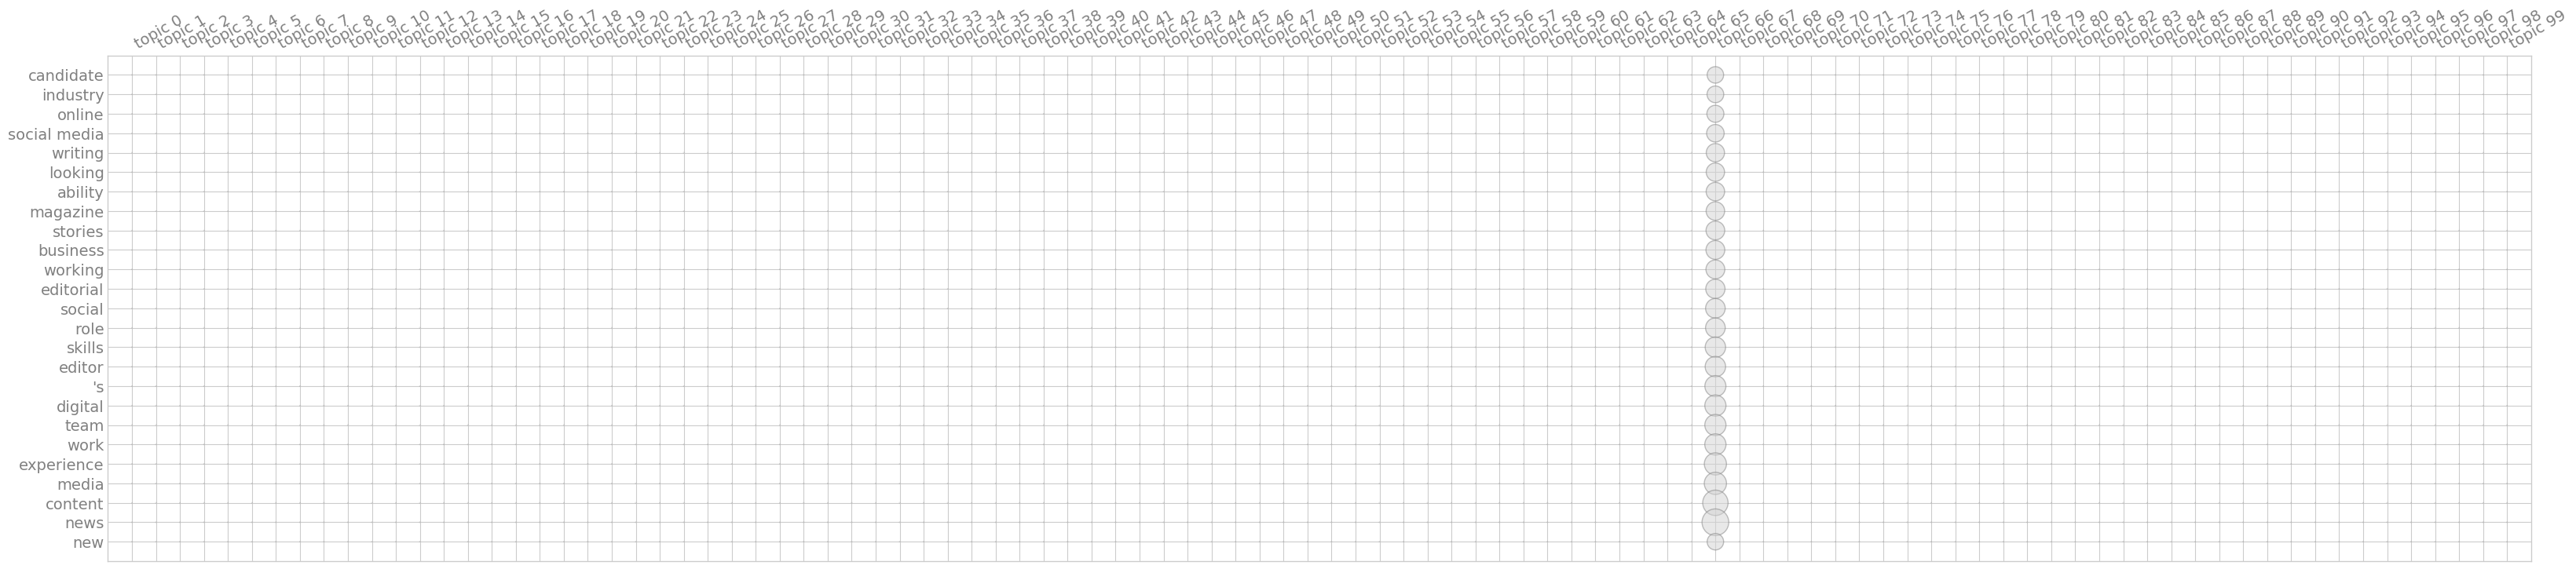

In [456]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, topics=-1,  n_terms=25, sort_terms_by='seriation')

In [74]:
bigram_counter = Counter()
trigram_counter = Counter()

for doc in corpus:
    bigrams = textacy.extract.ngrams(doc, 2)
    for bigram in bigrams:
        bigram_counter[bigram.text.lower()] += 1
    trigrams = textacy.extract.ngrams(doc, 3)
    for trigram in trigrams:
        trigram_counter[trigram.text.lower()] += 1

print(bigram_counter.most_common(40))
print(trigram_counter.most_common(40))

[('social media', 1875), ('successful candidate', 675), ('job description', 532), ('trinity mirror', 464), ('ideal candidate', 449), ('breaking news', 439), ("world's", 435), ('news stories', 431), ('editorial team', 413), ('contact details', 407), ('communication skills', 368), ('track record', 349), ('tight deadlines', 344), ("uk's", 334), ('closing date', 327), ('covering letter', 313), ('competitive salary', 297), ('writing skills', 275), ('mirror plc', 274), ('cover letter', 269), ("'s largest", 252), ('wall street', 251), ('street journal', 250), ('thomson reuters', 241), ('work closely', 237), ('key responsibilities', 236), ('new york', 225), ('digital content', 224), ('news editor', 223), ('editing skills', 218), ('team player', 215), ("'s leading", 215), ('content management', 207), ('national origin', 206), ('deputy editor', 180), ('experience working', 177), ('high quality', 174), ('wide range', 172), ('management skills', 172), ('working closely', 169)]
[('ability to work',

In [353]:
svos = [textacy.extract.subject_verb_object_triples(doc) for doc in corpus]
svo_counter = Counter()
for svo in svos:
    for s in svo:
        print(s)
        svo_counter[s] += 1
        
print(svo_counter.most_common(40))

(editors, to join, group)
(Ideal candidates, will have, hands)
(These, are, hands)
(that, will involve, close coordination)
(that, will involve, to produce)
(Qualifications Experienced editor, is, plus)
(correspondent, is, plus)
(knowledge, is, plus)
(skills, is, plus)
(ability, is, plus)
(knowledge, is, plus)
(Opportunity, is, policy)
(Opportunity, is, to provide)
(It, is, policy)
(It, is, to provide)
(we, consider, applications)
(Digital Publisher, serving, range)
(Journalist, to join, management)
(Journalist, to join, insurance desk)
(This, is, opportunity)
(asset management team, is, one)
(There, are, journalists)
(RISK.net editorial staff, comprises, journalists)
(There, will be, opportunities)
(position, offers, opportunity)
(we, operate, culture)
(you, have, access)
(We, offer, range)
(Competitive Salary, leave, Plan Onsite Monthly Massage Free eye tests)
(staff, can volunteer, amount)
(We, occupy, floors)
(journalism graduates, to join, technology division)
(Print, is, bonus)
(

(writing school, offering, courses)
(both, are, 200)
(seven, gained, book deals)
(course, includes, speaker sessions)
(Novel-Writing Course, brings, ingredients)
(Novel-Writing Course, brings, to)
(who, prefer, to study)
(Writing YA, is led, novels)
(Children’s Fiction Course, is led, novels)
(communications agency, is seeking, to fill)
(this, is, one)
(They, are, service marketing agency)
(Projects, include, working)
(HTML, creating, Experience)
(templates, Experience, websites)
(templates, Experience, email templates)
(templates, Experience, HTML5 banners)
(templates, Experience, css frameworks)
(WordPress Experience, using, version control)
(desire, would be, skills)
(Tempus, is seeking, grow)
(deputy editor, grow, content offering)
(deputy editor, grow, digital)
(deputy editor, grow, broadcast)
(candidate, has, track record)
(person, has, scope)
(They, have, contact book)
(candidate, understand, travels)
(Forming, is,  role)
(This, is,  role)
(Seeing, is, time)
(this, is, time)
(Th

(we, produce, recorded)
(There, be, opportunities)
(You, will need, to be)
(skills, would be, benefit)
(you, wish, to be considered)
(you, meet, criteria)
(you, should inform, manager)
(that, complement, editorial content)
(that, follow, house style)
(deadlines, are met, Select pictures)
(deadlines, are met, illustrations)
(You, will be required, to undertake)
(we, bring, celebrity news)
(we, bring, features)
(what, makes, celebrity story)
(SCOPE, will be expected, to offer)
(You, will be expected, to offer)
(team, to attend, parties)
(role, involved, liaising)
(3CC, is, content agency)
(candidate, will have, interest)
(This, is, opportunity)
(This, is, position)
(who, can hit, deadlines)
(Publisher, to lead, sales team)
(targets, are met, Maximise advertising revenue)
(lucyslater@atwoodtate.co.uk Atwood Tate, embraces, diversity)
(that, reflects, belief)
(we, will keep, CV)
(reader enquiries, Distribute, post)
(Assistant Social Media Editor, to join, London team)
(Cover, live, events)

(They, are, products)
(News UK, is, company)
(people, stretch, themselves)
(We, embrace, creativity)
(We, embrace, initiative)
(we, have, some)
(you, want, to work)
(News UK, is, place)
(We, accommodate, staff members)
(We, accommodate, applicants)
(customer magazines, focused, luxury)
(customer magazines, focused, travel)
(customer magazines, focused, style)
(Joining, will be, editor)
(Joining, will be, writer)
(candidate, will be, editor)
(candidate, will be, writer)
(This, is, where)
(You, will be offered, salary)
(venture, has been, hosting)
(features content, plays, part)
(Sun, plays, part)
(feature writers, generate, list)
(writer, is aiming, to make)
(News UK, is, company)
(We, are, company)
(which, has, journalism)
(They, are, products)
(News UK, is, company)
(people, stretch, themselves)
(We, embrace, creativity)
(We, embrace, initiative)
(we, have, some)
(you, want, to work)
(News UK, is, place)
(who, embraces, ways)
(who, embraces, to reach)
(person, will help, spearhead)
(p

(They, will need, to have)
(candidate, will be based, work)
(London, based, editorial teams)
(experience, Ability, to edit)
(world, reaching, people)
(journalists, deliver, news coverage)
(you, can bring, something)
(we, want, to hear)
(You, may have, career path)
(You, may have, education)
(You, may have, background)
(you, meet, qualifications)
(that, help, shape industries)
(happen, is, evolving process)
(we, count, to be)
(we, can do, that)
(we, seek, employees)
(Employment Opportunity, providing, workplace)
(Affirmative, providing, workplace)
(globalblue.com, guides, travellers)
(globalblue.com, guides, shopping cities)
(position, is, part)
(working hours, are, 5.30pm)
(it, takes, to be)
(Women, is, show)
(talk show, continues, to set)
(We, have, opportunity)
(Junior Researcher, to join, team)
(It, is, opportunity)
(You, will be, have)
(you, will have, experience)
(You, will have, approach)
(which, occasion include, weekends)
(which, occasion include, bank holidays)
(sense, is, mus

(who, buy, products)
(You, will be, face)
(we, want, to hear)
(UK’s, leading, insights practice)
(We, explore, intersection)
(flagship product, is, Library)
(role, will be, to develop)
(role, will be, increase)
(You, ’ll be expected, to grow)
(You, ’ll be expected, keep)
(you, ’ll be commissioning, sector reports)
(you, ’ll be commissioning, case studies)
(Gen Yers, handle, money)
(’s, have gone, gourmet)
(habits, have gone, gourmet)
(You, ’ll be expected, to research)
(You, ’ll be expected, write)
(you, ’ll have, travel budget)
(It, ’s, stimulating)
(Interviewing, thought, Proofing)
(Contributing, take, pride)
(planning, take, pride)
(maintaining, take, pride)
(Setting, take, pride)
(ensuring, take, pride)
(You, 'll be, wordsmith)
(you, ’ll be, discussing)
(you, ’ll be, thinking)
(you, ’ll be, applying)
(You, ’ll have, minimum)
(You, ’ll have, interest)
(this, is, role)
(you, ’ll have, understanding)
(you, ’ll have, contacts book)
(who, likes, to get)
(we, ’re, looking)
(You, will nee

(Everything, is designed, to inspire)
(Everything, is designed, enable)
(Everything, is designed, connect)
(Everything, is designed, have)
(who, share, passion)
(This, includes, pictorials)
(This, includes, gift books)
(who, are, to expand)
(who, are, to work)
(roles, will suit, candidates)
(You, ’ll help, London team)
(This, is, opportunity)
(CV, telling, us)
(you, can make, application)
(It, ’s, do culture)
(you, need, to be)
(We, ’re, team)
(someone, to help, support)
(you, can find, more)
(We, need, someone)
(You, ’ll need, motivated)
(You, will need, to learn)
(You, need, to have)
(You, need, be)
(we, will train, you)
(Essential, Attributes, Excellent)
(You, will have, work experience)
(we, ’d love, to hear)
(you, can help, us)
(you, can help, make)
(We, are, ’s)
(clients, include, councils)
(clients, include, companies)
(clients, include, universities)
(IFLScience, has become, destination)
(I, F*cking, Science)
(which, measures, engagement)
(person, to be, speaking)
(person, to b

(candidate, will have, years)
(Knowledge, is, must)
(Above, sees, potential)
(there, is, opportunity)
(we, favour, promotions)
(candidates, will need, to be)
(journalist, to join, business team)
(must, is, understanding)
(You, be, team player)
(Responsibilities, will include, helping)
(editor, will attend, planning meetings)
(that, distinguish, Ability)
(Editor, to oversee, News section)
(applicant, will have, background)
(who, will enhance, reputation)
(Tablet, offers, range)
(Pensions Expert, is seeking, reporter)
(candidate, will be, starter)
(who, is looking, to develop)
(Pensions Expert, is, news)
(Pensions Expert, is, information service)
(that, provides, them)
(It, publishes, online)
(It, publishes, weekly)
(candidate, will write, studies)
(Financial Times Ltd., is, Nikkei company)
(writers, need, to be)
(editors, need, to be)
(they, need, writing talent)
(they, need, passion)
(most, creating, quality service journalism)
(that, will be published, video platforms)
(Acts, may be a

(you, want, to work)
(News UK, is, place)
(You, ’ll play, part)
(You, engage, audience)
(This, is, time)
(you, are, qualifications)
(organisation, juggle, tasks)
(management skills, juggle, tasks)
(apply, email, us)
(you, want, job)
(you, want, to work)
(Tes Global, has been, supporting)
(mission, is, to help)
(We, are, home)
(We, are, community)
(Tes, is dedicated, teachers)
(mission, is, to enable)
(they, need, to excel)
(tools, supporting, them)
(technology, supporting, them)
(community, is, one)
(community, is, inspire)
(network, is, one)
(network, is, inspire)
(helping, inspire, educators)
(Tes, includes, Tes)
(Tes, includes, Education)
(Tes, includes, TES)
(heritage, includes, Tes)
(heritage, includes, Education)
(heritage, includes, TES)
(which, are, reads)
(Tes Global, has become, media provider)
(It, publishes, Rankings)
(These, are, facets)
(you, 'll be, marketing subscriptions)
(Acquisitions Marketing Executive, to join, team)
(Acquisitions Marketing Executive, to join, to d

(understanding, needs, ability)
(producing, produce, report)
(capturing, produce, report)
(defining, produce, report)
(ability, provides, professionals)
(Thomson Reuters, provides, professionals)
(they, need, to find)
(that, help, shape industries)
(We, ’ll bring, world)
(we, can do, that)
(we, seek, employees)
(responsibilities, encompass, liaison)
(Liaising, implement, opportunities)
(they, provide, content)
(that, need, fixing)
(individual, needs, to be)
(individual, needs, to be)
(Applicants, should send, CV)
(Wall Street Journal, is, news organization)
(that, provides, commentary)
(that, provides, analysis)
(Street Journal, engages, readers)
(Street Journal, engages, video)
(Building, includes, coverage)
(Building, includes, sports)
(Building, includes, health)
(Journal, includes, coverage)
(Journal, includes, sports)
(Journal, includes, health)
(It, holds, Prizes)
(position, offers, opportunity)
(editor, is, part)
(team, has, emphasis)
(editing experience, demonstrated, skills)
(

(You, must have, skills)
(You, must have, ability)
(world, reaching, people)
(journalists, deliver, news coverage)
(you, can bring, something)
(we, want, to hear)
(You, may have, career path)
(You, may have, education)
(You, may have, background)
(you, meet, qualifications)
(we, believe, matters)
(that, help, shape industries)
(happen, is, evolving process)
(we, count, to be)
(we, can do, that)
(we, seek, employees)
(Employment Opportunity, providing, workplace)
(Affirmative, providing, workplace)
(Seeking, is looking, supplements)
(Candidates, should have, track record)
(role, involves, rewriting)
(We, offer, salary)
(we, need, editor)
(we, need, commission)
(FM World brand, includes, website)
(This, is, opportunity)
(You, can expect, to be involved)
(role, involves, elements)
(You, demonstrate, exceptional written)
(You, demonstrate, communication skills)
(You, demonstrate, be)
(You, demonstrate, be)
(Adobe InDesign, master, software)
(You, will have, journalism credentials)
(We, off

(Network, is seeking, editor)
(You, will have, responsibility)
(that, defines, mission)
(magazine, increases, brand’s profile)
(magazine, increases, engagement)
(market, Developing, market relationships)
(that, deliver, value)
(brand Working, registered, readers)
(ambassador, to chair, conferences)
(role, will suit, team player)
(magazines, can develop, presence)
(This, is, opportunity)
(Junior Reporter, to join, London team)
(candidates, will have, experience)
(Requirements, include, experience Ability)
(skills Ability, Must have, qualification)
(Company, encourages, applications)
(Wall Street Journal, is, news organization)
(that, provides, commentary)
(that, provides, analysis)
(Street Journal, engages, readers)
(Street Journal, engages, video)
(Building, includes, coverage)
(Building, includes, sports)
(Building, includes, health)
(Journal, includes, coverage)
(Journal, includes, sports)
(Journal, includes, health)
(It, holds, Prizes)
(JA1-WSJ, is seeking, video journalist)
(Wall S

(We, continue, to win)
(B2B, includes, organisations)
(Writing, send, covering)
(you, 'll manage, brand channels)
(We, have, ambitions)
(we, need, to develop)
(we, approach, variety)
(you, understand, to develop)
(you, will ensure, consistent)
(we, want, someone)
(who, identifies, opportunities)
(proactively, identifies, opportunities)
(we, 'll give, you)
(rewards package, is, one)
(You, 'll get, leave)
(You, get, chance)
(you, 're playing, part)
(consultant, to help, us)
(consultant, to help, explore)
(we, would love, to hear)
(You, will provide, market knowledge)
(you, will have, fingers)
(We, will provide, day rate)
(you, to help, us)
(we, will keep, you)
(we, will keep, remunerated)
(we, will keep, stimulated)
(market, would like, to start)
(we, 'd love, to hear)
(Horse, is, horse lover)
(Horse, is, port)
(you, will have, vision)
(who, ride, them)
(that, supports, them)
(critique, must include, Guide idea)
(ideas, must include, Guide idea)
(we, are strengthening, coverage)
(who, wi

(you, ’re, interested)
(you, ’re, giving)
(they, are creating, Generating revenue)
(products, sell, Supporting)
(that, drives, users)
(You, should be, data junkie)
(What, Could Be, practices Light knowledge)
(What, Could Be, CSS styling)
(Mirror Online, is, tabloid)
(We, are, part)
(These, include, Mirror)
(These, include, Record)
(These, include, iconic)
(Contact Details, follow, link)
(position, would suit, senior)
(you, can meet, challenge)
(Contact Details, send, copy)
(Contact Details, send, words)
(you, are, candidate)
(we, have, number)
(you, will be joining, team)
(This, includes, reforming)
(We, need, individuals)
(you, have, skills)
(this, is, role)
(Job Description, Are, class journalist)
(you, want, to work)
(this, could be, role)
(Mirror Online, stays, step)
(role, will involve, nights)
(role, will involve, Description)
(role, will involve, weekends)
(Company Mirror Online, is, tabloid)
(We, are, part)
(These, include, Mirror)
(These, include, Record)
(These, include, titl

(This, is not, role)
(who, has, interest)
(you, can, interest)
(you, will be expected, to lead)
(you, will be required, to work)
(you, are, candidate)
(Closing date, is, Friday)
(Job Description, is looking, to strengthen)
(TheBusinessDesk.com, is looking, to strengthen)
(we, are seeking, applications)
(founded, operates, regions)
(journalists, enjoy, access)
(journalists, enjoy, leaders)
(journalists, enjoy, freedom)
(Applicants, are expected, to be)
(Applicants, are expected, be)
(who, has, experience)
(candidate, will be, ensure)
(candidate, will be, maintain)
(role, involves, working)
(editor, will be, discussions)
(They, be, face)
(You, will receive, 31,707)
(Metropolitan Police Service, is, UK)
(We, are, to protect)
(We, are, ’s)
(we, strive, to keep)
(press office, is, one)
(You, ’ll be joining, team)
(that, ’s, trailblazer)
(you, ’ll tell, Met story)
(you, ’ll tell, ’re)
(we, ’re, doing)
(people, can protect, themselves)
(we, ’re, fighting)
(This, involves, planning)
(This, inv

(Contact Details, should send, covering)
(applicants, should send, CV)
(applicants, should send, covering)
(Company, encourages, applications)
(reporter, to join, Cambridge office)
(We, fill, newspapers)
(We, fill, websites)
(This, is, chance)
(Masons, covers, stories)
(we, need, learner)
(we, need, team player)
(candidate, have, year)
(candidate, have, two)
(we, consider, applications)
(applicants, must have, NCTJ qualification)
(applicants, must have, similar)
(applicants, must have, driving licence)
(applicants, must have, knowledge)
(We, offer, salaries)
(Contact Details, cover, letter)
(Contact Details, cover, CV)
(cuttings, cover, letter)
(cuttings, cover, CV)
(Hull, is seeking, to recruit)
(Daily Mail, is seeking, to recruit)
(duties, Work, to create)
(responsibilities, Work, to create)
(which, drive, response Monitor)
(which, drive, media)
(which, drive, to spot)
(which, drive, capitalise)
(which, maximises, Plan)
(which, helps, enhance)
(which, meets, standards)
(people, use, 

(you, need, to be)
(editing skills, will be, bedrock)
(we, put, name)
(it, 's, pleasure)
(You, teamwork, to ensure)
(We, ’re, branching)
(you, have, experience)
(we, publish, content)
(magazine, continues, to thrive)
(you, ’ll be, industry expert)
(you, ’ll be, editor’s letter)
(you, need, to be)
(which, upholds, legacy)
(role, will give, you)
(role, will give, opportunity)
(skills, would be, advantage)
(confidence, would be, advantage)
(you, need, understanding)
(you, ’re, editor)
(we, ’d love, to hear)
(company, is, media business)
(portfolio, includes, range)
(You, can see, work)
(You, can see, job alerts)
(Categories   editors, feed, specialist writers)
(proofreaders, feed, specialist writers)
(management editors, feed, specialist writers)
(feed   proofreaders, feed, specialist writers)
(you, looking, to join)
(you, can express, yourself)
(people, want, to work)
(people, want, to work)
(you, to be, part)
(Content Editor, to join, team)
(you, 're supporting, content)
(Constructing, 

(journalists broadcast journalists, feed, features)
(jobs, feed, media)
(writers, feed, media)
(World Economic Forum, is, Organization)
(Forum, engages, business)
(Forum, engages, leaders)
(Analysis team, manages, knowledge networks)
(Global Future Councils, supports, work)
(Global Future Councils, supports, to enhance)
(Global Future Councils, supports, shape)
(Forum, has developed, 120)
(that, highlight, trends)
(Duties, Oversee, curation)
(responsibilities, Oversee, curation)
(Explore, using, Forum communities)
(Explore, using, to capture)
(Explore, using, events)
(highlight interlinkages, using, Forum communities)
(highlight interlinkages, using, to capture)
(highlight interlinkages, using, events)
(think tanks, approve, content)
(government, approve, content)
(industry, approve, content)
(industry, Help coordinate, ’s degree)
(industry, Help coordinate, equivalent)
(content, Help coordinate, ’s degree)
(content, Help coordinate, equivalent)
(who, enjoys, working)
(Excellent, writt

(tech parkHaslar RoadGosportHampshirePO12, 2AGUnited, to reveal)
(Production Editor, will ensure, running)
(New Internationalist Publications Ltd, is, operative)
(You, will bring, to)
(You, will be, starter)
(This, is, a week position)
(You, contact, us)
(NI, aims, to be)
(jobs, feed, specialist writers)
(assistants, feed, specialist writers)
(editors, feed, specialist writers)
(management editors, feed, specialist writers)
(  section editors, feed, specialist writers)
(section editors, feed, specialist writers)
(specialist writers, feed, media)
(journalist, to join, GC magazine)
(journalist, to join, Legalease)
(editor, to join, GC magazine)
(editor, to join, Legalease)
(management, focused, features)
(GC, is, magazine)
(mandate, includes, issues)
(mandate, includes, affairs)
(We, have, readership)
(candidate, would need, to have)
(They, would need, to be focused)
(They, would need, driven)
(We, offer, dependent)
(day duties, will include, Writing)
(Planning, thought, leadership piece

(you, might have, experience)
(You, ’ll need, to be)
(You, ’ll need, management skills)
(we, ’ll give, you)
(give, is, one)
(You, ’ll get, leave)
(You, get, chance)
(you, playing, part)
(’re, playing, part)
(Senior, features,   features)
(AEIDL, seeks, driven)
(AEIDL, seeks, Journalist)
(LIFE, is, instrument)
(AEIDL, performs, task)
(role, would suit, individual)
(candidate, have, flair)
(you, match, job description)
(interviews, will take, place)
(website, will involve, producing)
(website, will involve, leads sent)
(This, will involve, producing)
(This, will involve, leads sent)
(Web Journalist, will help, implement)
(events, featured, projects)
(This, will involve, meetings)
(This, will involve, involvement)
(LIFEnews, is published, times)
(task, may involve, opportunities)
(Knowledge, is, advantage)
(job alerts, to get, jobs)
(Senior, features, broadcast journalists)
(broadcast journalists, feed, news feed)
(section editors, feed, specialist writers)
(section editors, feed, special